In [ ]:
import pandas as pd
import numpy as np
import sklearn
import statsmodels.formula.api as sm
from scipy import stats
from scipy.stats import median_test
import scipy
import os

### 1. Combine data and define labels

In [ ]:
folder = "outputs/difficult_labels/raw"
files = [os.path.join(folder, x) for x in os.listdir(folder)]

df = pd.DataFrame()

for f in files:
    int_df = pd.read_csv(f)
    df = pd.concat([df, int_df])

df.to_csv("outputs/summary/combined.csv", index = False)

for occupation in list(df.occupation.unique()):
    print(f"Occupation: {occupation}")
    print(len(df[df["occupation"] == occupation]))

races = ['caucasian','black','asian','indian']
df = df[df["race"] != "base"]
models = df['model'].unique()
occupations = df['occupation'].unique()

df = pd.read_csv("outputs/summary/combined.csv")

#models = ['clip','laion-clip.vit-l-14.openai','laion-clip-small','laion-clip.vit-l-14.laion400m','laion-clip' ,'laion-clip.vit-l-14.laion2b', 'flava']

In [125]:
df.filepaths = df.filepaths.astype(str)
df['img_id'] = df["filepaths"].apply(lambda x: x.split("/")[:-1])
df['img_id'] = df['img_id'].apply(lambda x: "_".join(x))

In [126]:
df['race'] = pd.Categorical(df['race'], categories=['caucasian','black','asian','indian'])
df['model'] = pd.Categorical(df['model'], categories=models)
# Dummy for correct
df["correct"] = 0
df.loc[df["occupation"] == df["top_pred"], "correct"] = 1
df["correct"].value_counts()

1    157502
0     34498
Name: correct, dtype: int64

In [127]:
for occupation in list(df.occupation.unique()):
    print(f"Occupation: {occupation}")
    print(len(df[df["occupation"] == occupation]))

occupations = ["doctor", "pilot", "firefighter", "chef", "mechanic"]
OCCUPATIONS = {
     "doctor": ["doctor", "physician assistant", "midwife", "nurse", "pharmacist", "clinical laboratory technician", "emergency medical technician", "veterinarian"],
     "chef": ["chef", "line cook", "waiter", "host", "server", "food preparation worker", "cafeteria attendant", "dishwasher"],
     "mechanic": ["mechanic", "automobile engineer", "mechanical engineer", "civil engineer", "electrical engineer", "industrial engineer", "aerospace engineer", "petroleum engineer"],
     "pilot": ["pilot", "flight steward", "flight stewardess", "airline reservation agent", "aircraft fueler", "driver", "air traffic controller", "aircraft engineer"],
     "firefighter": ["firefighter", "fire chief", "coast guard", "paramedic", "police officer", "pilot", "security guard", "soldier"]
}

Occupation: mechanic
38400
Occupation: chef
38400
Occupation: pilot
38400
Occupation: firefighter
38400
Occupation: doctor
38400


### 2. Generate regression plots

Results for doctor
Results for pilot
Results for firefighter
Results for chef
Results for mechanic


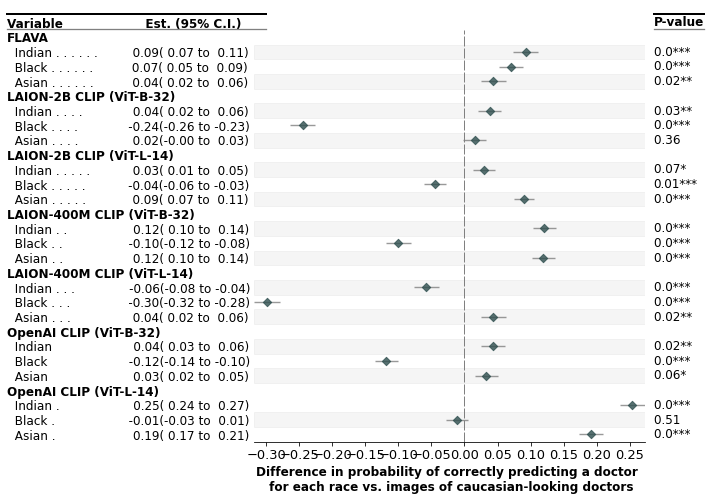

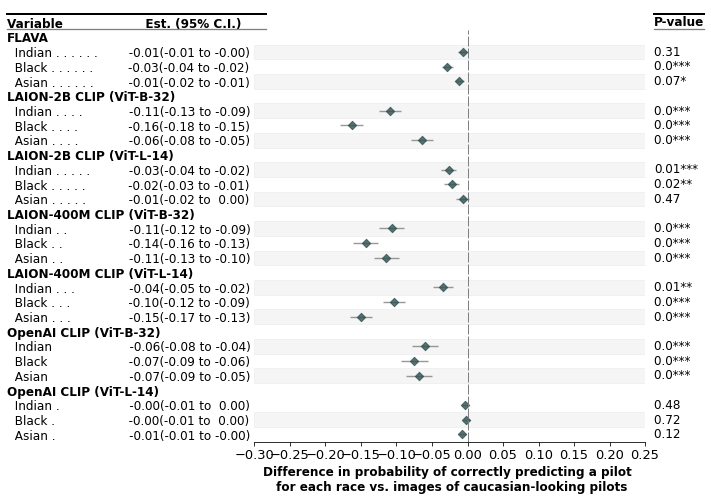

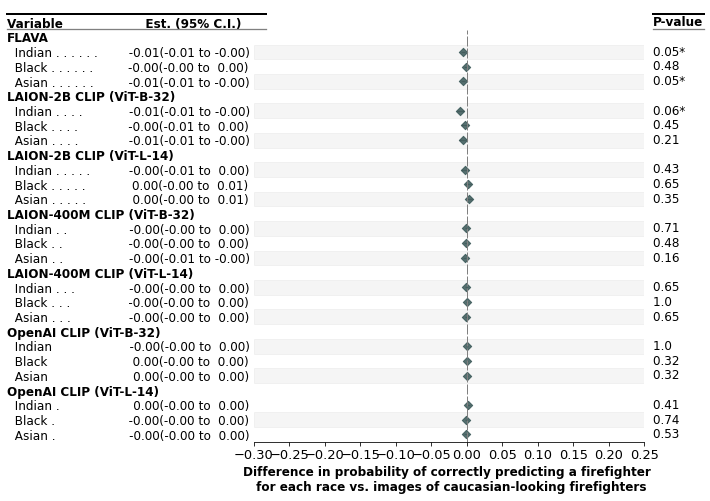

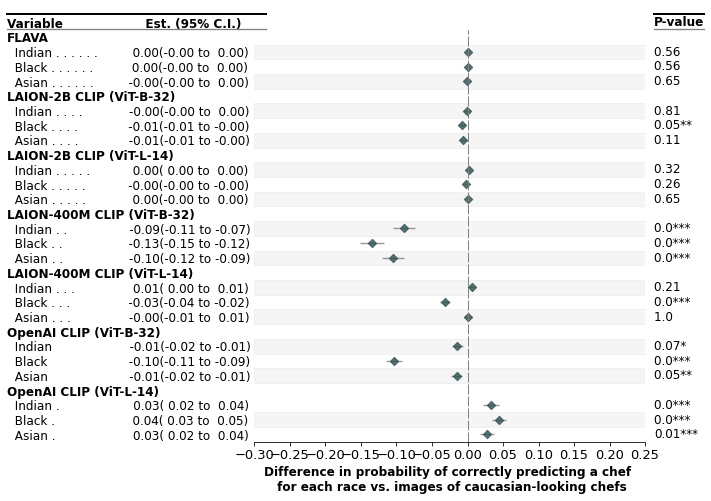

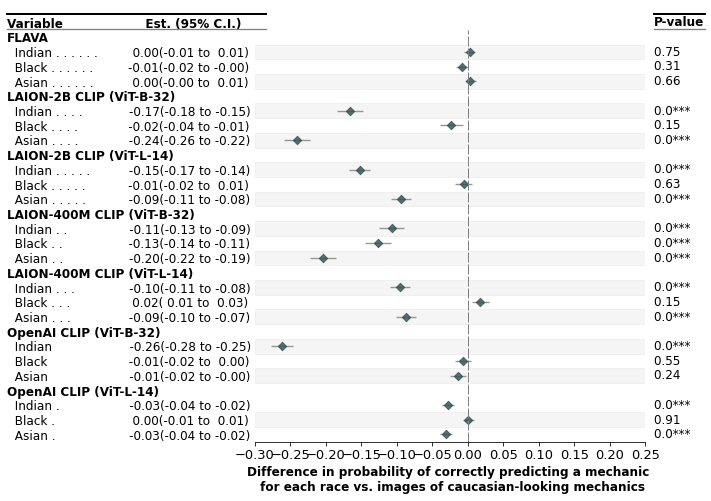

In [138]:
import forestplot as fp
import matplotlib.pyplot as plt
import pdb
import cv2

# Test 1: Are there racial discrepancies in occupation classification by race?
# Base group is Caucasian


rename_race = {"C(race)[T.black]": "Black", "C(race)[T.asian]": "Asian", "C(race)[T.indian]": "Indian", "Intercept": "White"}
rename_models = {'clip': "OpenAI CLIP (ViT-B-32)", 'flava': "FLAVA", 'laion-clip-small': "LAION-400M CLIP (ViT-B-32)",'laion-clip': "LAION-2B CLIP (ViT-B-32)",
                 'laion-clip.vit-h-14.laion2b': "LAION-2B CLIP (ViT-H-14)", 'laion-clip.vit-l-14.openai': "OpenAI CLIP (ViT-L-14)", 'laion-clip.vit-l-14.laion2b': "LAION-2B CLIP (ViT-L-14)",'laion-clip.vit-l-14.laion400m': "LAION-400M CLIP (ViT-L-14)",
                 }

for occupation in occupations:
    tmp = df[df["occupation"] == occupation]
    i=0
    results_df = pd.DataFrame()
    for model in models:
        tmp2 = tmp[tmp["model"] == model]
        results = sm.ols(formula='correct ~ C(race)', data=tmp2).fit(cov_type = 'cluster', cov_kwds = {'groups': tmp2['img_id']})
        res_df = pd.concat([pd.DataFrame({"model": [model]*4}),\
            results.params.to_frame().reset_index().rename({0:"coef", "index": "race"}, axis = 1),\
            results.bse.to_frame().reset_index().rename({0:"stddev", "index": "index1"}, axis = 1),\
            results.pvalues.to_frame().reset_index().rename({0:"pval", "index": "index2"}, axis = 1),\
            ], axis = 1).drop(["index1", "index2"], axis=1)

        res_df["race"] = [rename_race[x] + " " + " ".join(["."]*i) for x in res_df["race"]]
        res_df = res_df[["White" not in x for x in res_df.race]]
        res_df["n"] = int(results.nobs/4)

        results_df = pd.concat([results_df, res_df])
        i+=1
    
    results_df['coef'] = [round(x, 5) for x in results_df['coef']]
    results_df = results_df.reset_index(drop = True)
    results_df['ll'] = results_df['coef']-results_df['stddev']
    results_df['hl'] = results_df['coef']+results_df['stddev']
    results_df['model'] = [rename_models[x] for x in results_df['model']]

    print(f"Results for {occupation}")
    fp.forestplot(results_df,  # the dataframe with results data
            estimate="coef",  # col containing estimated effect size 
            ll="ll", hl="hl",
            varlabel="race",  # column containing variable label
            groupvar="model",  # Add variable groupings 
            sort=True,  # sort in ascending order (sorts within group if group is specified)
            table=True,  # Format as a table
            annote=["est_ci"],  # columns to report on left of plot
            annoteheaders=["Est. (95% C.I.)"],  # ^corresponding headers
            #decimal_precision = 2,
            color_alt_rows=True,
            pval="pval",
            sortby = "race",
            rightannote=["formatted_pval"],
            right_annoteheaders=["P-value"],
            xlabel=f"Difference in probability of correctly predicting a {occupation} \n for each race vs. images of caucasian-looking {occupation}s",
            xticks = [-0.3, -0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25],
            figsize = (8, 8),
            **{"marker": "D",  # set maker symbol as diamond
                "markersize": 35,  # adjust marker size
                "xlinestyle": (0, (10, 2)),  # long dash for x-reference line 
                "xlinecolor": "#808080",  # gray color for x-reference line
                "xtick_size": 13,  # adjust x-ticker fontsize
                'fontfamily': 'sans-serif',
            }  
            )
    #plt.show()
    plt.savefig(f"../plots/regression_plot_{occupation}.png", bbox_inches="tight")
  

### 3. Generate graphs for misclassified labels for each occupation

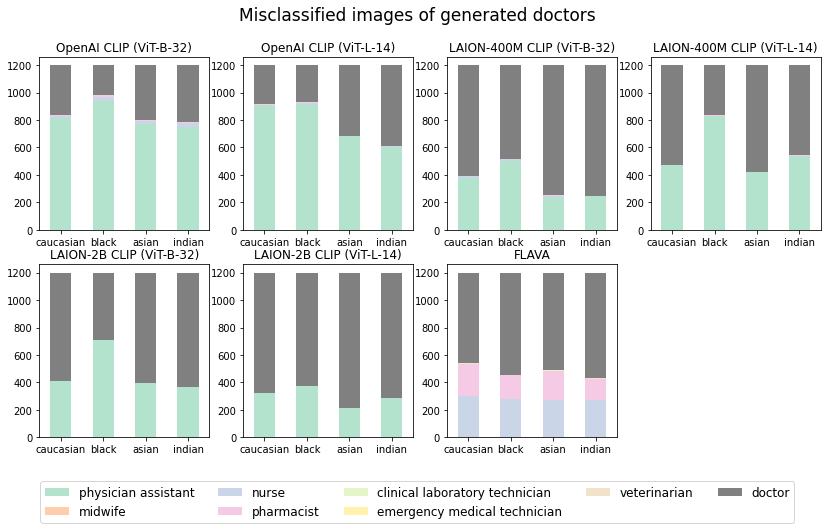

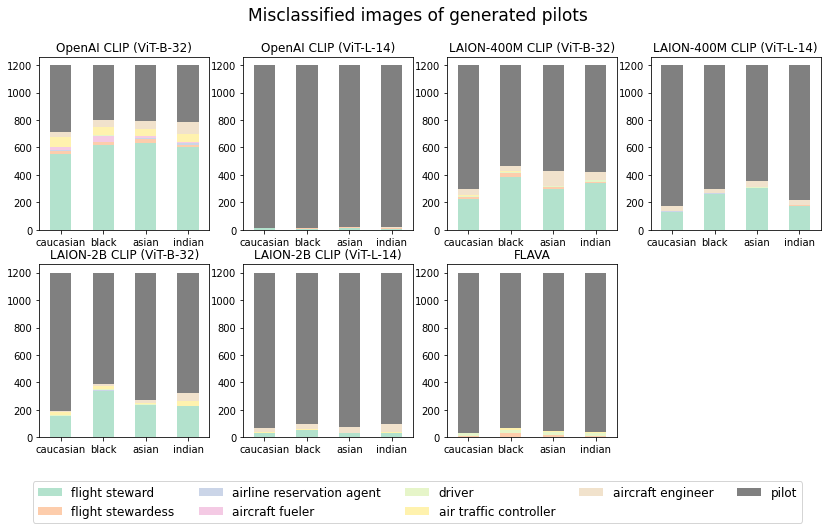

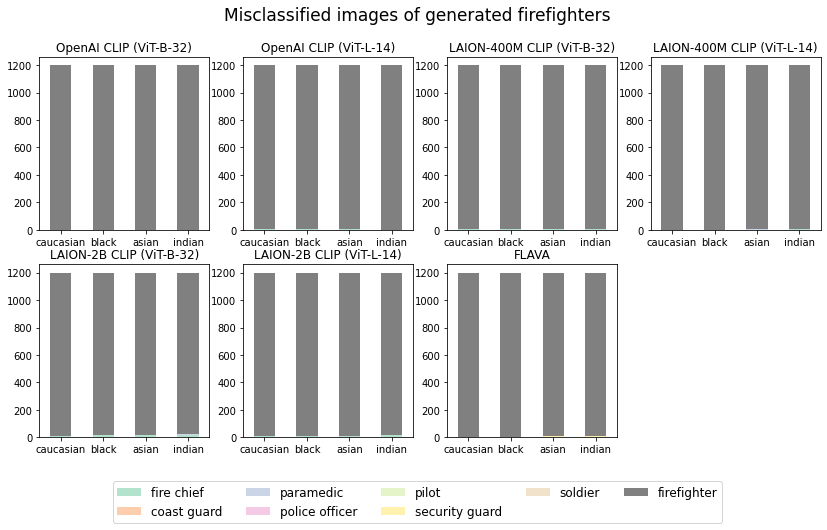

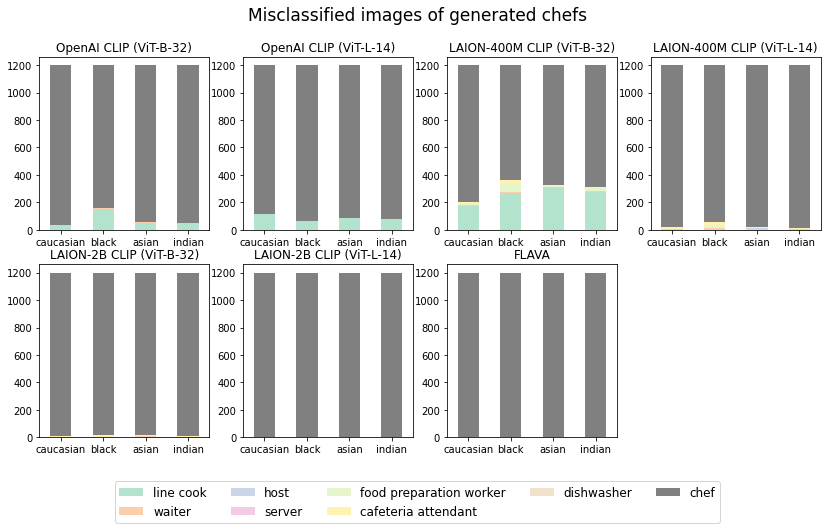

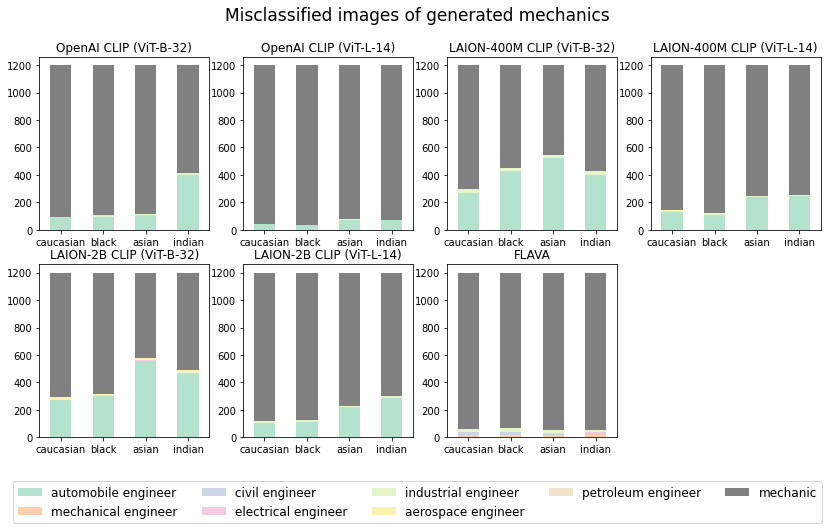

In [135]:
#Misclassified Labels
for occupation in occupations:

    fig, ax = plt.subplots(2, 4, figsize = (14, 7))
    i=0
    for model in models:
        tmp_df = df[(df["occupation"] == occupation)*(df["model"] == model)]
        other_occs = OCCUPATIONS[occupation]
        other_occs = [x for x in other_occs if x!=occupation]
        colors = iter([plt.cm.Pastel2(i) for i in range(len(other_occs))])
        color_dict = {k: v for k, v in zip(other_occs, colors)}
        color_dict[occupation] = "grey"
        sorter = other_occs + [occupation]

        to_plot = tmp_df.groupby(["race", "top_pred"])["occupation"].count().reset_index()
        to_plot = pd.pivot(to_plot, index='race', columns='top_pred', values='occupation').reindex(columns=sorter)
        
        to_plot.plot.bar(stacked=True, color=color_dict, rot=0, title = f'{rename_models[model]}', ax = ax[i//4,i%4], xlabel='', legend=False) #ax[i//2,i%2]
        i+=1

    fig.delaxes(ax[1,3])

    bars, labels = fig.axes[-1].get_legend_handles_labels()
    fig.legend(bars, labels, loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=5, fontsize=12)
    fig.suptitle(f'Misclassified images of generated {occupation}s', fontsize=17)
    plt.savefig(f"../plots/misclassification_plot_{occupation}.png", bbox_inches="tight")

### 4. Overall accuracy numbers

In [130]:
print(f"Overall Accuracy")
for model in models:
    model_df = df[df["model"] == model]
    model_correct = model_df[model_df["correct"] == 1]
    acc = np.round(len(model_correct)/len(model_df),3)
    #acc = model_df.probs.mean()
    print(f"{rename_models[model]}: {acc}")
          
for occupation in list(df.occupation.unique()):
    print("\n")
    print(f"Occupation: {occupation}")
    for model in models:
        model_df = df[(df["model"] == model) & (df["occupation"] == occupation)]
        model_correct = model_df[model_df["correct"] == 1]
        acc = np.round(len(model_correct)/len(model_df),3)
        acc = model_df.probs.mean()
        print(f"{rename_models[model]}: {acc}")

Overall Accuracy
OpenAI CLIP (ViT-B-32): 0.686
OpenAI CLIP (ViT-L-14): 0.841
LAION-400M CLIP (ViT-B-32): 0.751
LAION-400M CLIP (ViT-L-14): 0.824
LAION-2B CLIP (ViT-B-32): 0.798
LAION-2B CLIP (ViT-L-14): 0.901
FLAVA: 0.901


Occupation: mechanic
OpenAI CLIP (ViT-B-32): 0.7110713936203935
OpenAI CLIP (ViT-L-14): 0.8524716253842567
LAION-400M CLIP (ViT-B-32): 0.5809516091823969
LAION-400M CLIP (ViT-L-14): 0.7729818863959511
LAION-2B CLIP (ViT-B-32): 0.5731119768690386
LAION-2B CLIP (ViT-L-14): 0.7108319729450594
FLAVA: 0.9279412468735597


Occupation: chef
OpenAI CLIP (ViT-B-32): 0.7268476243720834
OpenAI CLIP (ViT-L-14): 0.7163134630347051
LAION-400M CLIP (ViT-B-32): 0.6000779056951839
LAION-400M CLIP (ViT-L-14): 0.9410680262679815
LAION-2B CLIP (ViT-B-32): 0.9110197695671495
LAION-2B CLIP (ViT-L-14): 0.9489010135537614
FLAVA: 0.9956456866470899


Occupation: pilot
OpenAI CLIP (ViT-B-32): 0.3090458049989238
OpenAI CLIP (ViT-L-14): 0.8838060000666631
LAION-400M CLIP (ViT-B-32): 0.57271202

### 5. Fairness metrics for each model and statistical significance

In [139]:
# Print standard deviation for occupations
print(f"Overall Fairness")
for model in models:
    model_std = df[df["model"] == model].groupby("img_id")["probs"].std()
    model_std = model_std.median()
    model_std = round(model_std, 3)
    fairness = 1-model_std
    print(f"{rename_models[model]}: {fairness}")
    
# Now for each occupation
for occupation in occupations:
    print("\n")
    print(f"Occupation: {occupation}")
    for model in models:
        model_std = df[(df["model"] == model) & (df["occupation"] == occupation)].groupby("img_id")["probs"].std()
        model_std = model_std.median()
        model_std = round(model_std, 3)
        fairness = 1-model_std
        print(f"{rename_models[model]}: {fairness}")

Overall Fairness
OpenAI CLIP (ViT-B-32): 0.884
OpenAI CLIP (ViT-L-14): 0.903
LAION-400M CLIP (ViT-B-32): 0.835
LAION-400M CLIP (ViT-L-14): 0.862
LAION-2B CLIP (ViT-B-32): 0.849
LAION-2B CLIP (ViT-L-14): 0.908
FLAVA: 0.983


Occupation: doctor


KeyError: nan

In [ ]:
def t_test_compare(model1, model2, occupation=None):
    # Get my standard deviations for each image
    print(df.occupation.unique())
    stdev1 = list(df[df["model"] == model1].groupby("img_id")["probs"].std())
    stdev2 = list(df[df["model"] == model2].groupby("img_id")["probs"].std())
    assert len(stdev1) == len(stdev2)
    
    # Run test of medians
    res = scipy.stats.median_test(stdev1, stdev2)
    t, pval = res[0], res[1]
    print(f"{model1} vs {model2}: {t}, {pval}")

    return t, pval

In [ ]:
models1 = []
models2 = []
pvals = []

for i in range(len(models)):
    for j in range(i+1, len(models)):
        model1 = models[i]
        model2 = models[j]
        t, pval = t_test_compare(model1, model2)
        models1.append(model1)
        models2.append(model2)
        pvals.append(pval)

['mechanic' 'chef' 'pilot' 'firefighter' 'doctor']
clip vs laion-clip.vit-l-14.openai: 89.09633333333333, 3.7604732129477644e-21
['mechanic' 'chef' 'pilot' 'firefighter' 'doctor']
clip vs laion-clip-small: 435.483, 1.04119222783269e-96
['mechanic' 'chef' 'pilot' 'firefighter' 'doctor']
clip vs laion-clip.vit-l-14.laion400m: 28.616333333333333, 8.823477716156777e-08
['mechanic' 'chef' 'pilot' 'firefighter' 'doctor']
clip vs laion-clip: 130.20833333333334, 3.68949303863107e-30
['mechanic' 'chef' 'pilot' 'firefighter' 'doctor']
clip vs laion-clip.vit-l-14.laion2b: 93.987, 3.176029635560685e-22
['mechanic' 'chef' 'pilot' 'firefighter' 'doctor']
clip vs laion-clip.vit-h-14.laion2b: 8.216333333333333, 0.004151499980404934
['mechanic' 'chef' 'pilot' 'firefighter' 'doctor']
clip vs flava: 1326.675, 1.8047421369566815e-290
['mechanic' 'chef' 'pilot' 'firefighter' 'doctor']
laion-clip.vit-l-14.openai vs laion-clip-small: 799.8003333333334, 5.9631022851588044e-176
['mechanic' 'chef' 'pilot' 'fire

In [ ]:
pv = pd.DataFrame({
    "model1": models1,
    "model2": models2,
    "p_value": pvals
})

In [ ]:
# Apply Bonferroni correction for multiple testing
pv["adjusted_p_value"] = 0.05 / len(pv)
pv["sig"] = 0
pv.loc[pv["p_value"] <= 0.05 / len(pv), "sig"]=1

In [ ]:
pv

,model1,model2,p_value,adjusted_p_value,sig
0,clip,laion-clip.vit-l-14.openai,3.760473e-21,0.001786,1
1,clip,laion-clip-small,1.041192e-96,0.001786,1
2,clip,laion-clip.vit-l-14.laion400m,8.823478e-08,0.001786,1
3,clip,laion-clip,3.689493e-30,0.001786,1
4,clip,laion-clip.vit-l-14.laion2b,3.176030e-22,0.001786,1
5,clip,laion-clip.vit-h-14.laion2b,4.151500e-03,0.001786,0
6,clip,flava,1.804742e-290,0.001786,1
7,laion-clip.vit-l-14.openai,laion-clip-small,5.963102e-176,0.001786,1
8,laion-clip.vit-l-14.openai,laion-clip.vit-l-14.laion400m,1.865890e-24,0.001786,1
9,laion-clip.vit-l-14.openai,laion-clip,1.226157e-68,0.001786,1
